根据布林带制定均值回归策略。金融20170924褚天舒

* （a）导出ptSl=[0，2]和t1的元标签，其中numDays=1。计算的每日标准偏差作为trgt。
* （b）训练随机森林，以决定是否进行交易。可用作特征：波动性、相关性和交叉移动平均线。
* （c）从原始模型预测的准确度是多少？（即，如果二级模型不过滤头寸）准确度、召回率和FI-scores是多少？
* （d）原始模型的预测精度如何？准确度、召回率和FI-scores是多少？

In [83]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml #这个安装了很久，需要安装cvxpy和一堆其他的，换了台电脑不熟悉，一直报错

In [84]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline 

# 加载数据

In [5]:
# Read in data
data = pd.read_csv('sample_dollar_bars.csv')#等额抽样
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [6]:
data

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499
...,...,...,...,...,...,...,...
2012-07-30 12:30:28.642,1379.25,1380.00,1377.50,1377.75,50843,70116589.50,17923
2012-07-30 13:29:21.258,1377.75,1380.00,1377.00,1379.25,50782,70014483.25,14040
2012-07-30 13:35:05.407,1379.25,1383.25,1379.00,1382.50,50675,70001889.25,12017


#### RSI的原理简单来说是以数字计算的方法求出买卖双方的力量对比，譬如有100个人面对一件商品，如果50个人以上要买，竞相抬价，商品价格必涨。相反，如果50个人以上争着卖出，价格自然下跌。强弱指标理论认为，任何市价的大涨或大跌，均在0-100之间变动，根据常态分配，认为RSI值多在30-70之间变动，通常80甚至90时被认为市场已到达超买状态，至此市场价格自然会回落调整。当价格低跌至30以下即被认为是超卖状态，市价将出现反弹回升。

In [7]:
def bbands(close_prices, window, no_of_stdev):#布林带
    # rolling_mean = close_prices.rolling(window=window).mean()移动均值
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()#指数加权滑动
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

## 拟合主要模型：基于均值回归的布林带策略。


In [8]:
# compute bands
window = 20
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)#20天平均线加减1.5标准差

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2012-05-11 10:24:29.981,1351.00,1353.75,1348.75,1350.75,51806,70000598.00,17586,1353.822004,1359.891373,1347.752634
2012-06-25 14:19:05.963,1308.75,1310.25,1307.50,1307.75,53515,70033514.00,13551,1315.543437,1326.722029,1304.364845
2012-04-10 14:08:42.762,1374.00,1374.25,1372.25,1373.25,50981,70008912.75,11416,1376.659423,1381.890211,1371.428634
2011-08-01 19:40:12.561,1279.25,1284.75,1279.00,1283.25,54603,70000056.25,8851,1278.366234,1285.868914,1270.863553
2012-07-20 15:23:31.360,1363.50,1364.50,1361.50,1362.75,51365,70001193.75,11832,1364.576955,1369.436763,1359.717148
2012-03-22 14:10:04.224,1388.50,1390.75,1387.50,1389.25,50384,70006898.00,12783,1392.046186,1399.365670,1384.726703
2011-11-01 11:03:24.580,1226.25,1229.00,1222.50,1224.75,57136,70002797.25,17946,1243.828544,1264.748754,1222.908333
2012-03-08 18:28:42.024,1364.75,1365.50,1364.00,1364.25,51293,70002242.00,11170,1360.518794,1367.567391,1353.470197
2012-04-05 10:50:58.126,1385.50,1387.25,1384.00,1387.00,50522,70005606.25,14896,1392.462396,1398.402538,1386.522255


In [9]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)#通过滞后信号消除前瞻性偏差，往后一次，统计击穿次数

 1.0    332
-1.0    315
Name: side, dtype: int64


In [11]:
long_signals

date_time
2011-07-31 23:31:58.810    False
2011-08-01 02:55:17.443    False
2011-08-01 07:25:56.319    False
2011-08-01 08:33:10.903    False
2011-08-01 10:51:41.842    False
                           ...  
2012-07-30 12:30:28.642    False
2012-07-30 13:29:21.258    False
2012-07-30 13:35:05.407    False
2012-07-30 13:43:43.711    False
2012-07-30 13:54:26.158    False
Length: 10000, dtype: bool

In [92]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)#删去空值

In [93]:
print(data.side.value_counts())

 1.0    330
-1.0    315
Name: side, dtype: int64


### 事件: CUSUM Filter  预测触发CUSUM事件时将发生什么。使用MAvg策略的信号来确定头寸的方向。

In [94]:
# Compute daily volatility日波动率
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=20)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean() * 0.1)

# Compute vertical barrier竖直隔栏
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [95]:
pt_sl = [0, 2]#隔栏有效状态，不止盈，有期限
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

2020-03-26 15:19:49.222422 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [96]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    244
-1.0    232
Name: side, dtype: int64

### 主模型结果

In [97]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))#宏平均计算出每一个类的Precison和Recall后计算F1，最后将F1平均。

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       278
           1       0.42      1.00      0.59       198

    accuracy                           0.42       476
   macro avg       0.21      0.50      0.29       476
weighted avg       0.17      0.42      0.24       476

Confusion Matrix
[[  0 278]
 [  0 198]]

Accuracy
0.41596638655462187


* 类不平衡——更多的被归类为“不交易”
* 元标记表明有许多假阳性
* sklearn的混淆矩阵是[[TN，FP][FN，TP]]

## 拟合元模型

训练随机森林来决定是否交易（即分别为1或0），因为前面的模型已经决定了方向（-1或1）
创建以下特征：
* 波动性
* 序列相关性
* 相关序列在不同滞后下的收益
* SMavg战略的各方

In [98]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2011-08-01 13:56:56.220,1293.25,1294.00,1292.00,1292.25,54159,70025279.50,12010,1299.274139,1306.997503,1291.550774,13.0,NaN
2011-08-01 14:00:21.448,1292.25,1292.75,1286.75,1286.75,54266,70000564.25,10157,1297.739330,1307.398685,1288.079975,9.0,NaN
2011-08-01 14:01:38.747,1286.75,1287.00,1284.00,1284.50,54475,70034099.00,8778,1296.160007,1307.414979,1284.905035,7.0,1.0
2011-08-01 14:03:22.782,1284.50,1285.00,1278.75,1279.00,54589,70000494.25,10823,1294.161065,1307.765012,1280.557117,5.0,1.0
2011-08-01 14:04:31.604,1279.00,1281.50,1276.00,1276.00,55049,70397187.25,10651,1292.089531,1307.714068,1276.464995,5.0,1.0


## 特征

In [99]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum动量
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)
raw_data['mom6'] = raw_data['close'].pct_change(periods=6)

# Volatility
window_stdev = 20
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)序列相关，lag为延迟
window_autocorr = 20

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)
raw_data['autocorr_6'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=6), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 12
slow_window = 26

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

In [100]:
# Add Trending signals  macd
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [101]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [102]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### 获取指定事件的数据

In [103]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,mom6,volatility,...,autocorr_3,autocorr_4,autocorr_5,autocorr_6,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2011-08-02 17:02:16.995,16.0,1.0,-0.000990,-0.000990,-0.004339,-0.005516,-0.006299,-0.004732,-0.005320,0.001208,...,-0.250441,0.257479,-0.024303,-0.440645,-0.003359,-0.001183,-0.000788,0.001576,-0.000591,-1.0
2011-08-02 18:06:11.084,19.0,1.0,-0.002381,-0.002379,-0.002971,-0.005533,-0.005925,-0.005336,-0.002971,0.001455,...,-0.426201,-0.055423,0.153338,-0.108872,-0.000594,-0.002572,-0.000395,0.000593,0.002374,-1.0
2011-08-03 14:27:33.970,26.0,1.0,-0.003217,-0.003212,-0.005608,-0.007199,-0.008190,-0.008982,-0.006205,0.002017,...,-0.158916,-0.190979,-0.075624,0.023092,-0.002406,-0.001601,-0.000999,-0.000799,0.002798,-1.0
2011-08-03 14:37:04.871,24.0,1.0,-0.002624,-0.002620,-0.004627,-0.003424,-0.006625,-0.009013,-0.010598,0.002055,...,0.019419,-0.113745,-0.010705,0.102100,-0.002014,0.001208,-0.003217,-0.002406,-0.001601,-1.0
2011-08-03 17:48:20.242,76.0,-1.0,0.004200,0.004208,0.007439,0.010079,0.008655,0.011302,0.012119,0.002137,...,0.153260,0.236590,-0.046550,-0.350620,0.003212,0.002617,-0.001410,0.002620,0.000808,1.0


#### 拟合模型

In [104]:
print(X.index.min())
print(X.index.max())

2011-08-02 17:02:16.995000
2012-07-26 11:53:52.356000


* 平衡类

In [105]:
# Split data into training, validation and test sets
X_training_validation = X['2011-08-02':'2012-07-01']
y_training_validation = y['2011-08-02':'2012-07-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [106]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    200
1    154
Name: bin, dtype: int64

In [107]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    200
0    200
Name: bin, dtype: int64

In [108]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

* 建模

In [163]:
parameters = {'max_depth':[2, 3, 4, 5, 7, 9],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', n_jobs=3)#网格优化
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [164]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.5125625 0.651375  0.67825   0.6785625 0.685125  0.689875  0.683375
 0.544875  0.6873125 0.726875  0.743375  0.76      0.7585    0.753125
 0.5743125 0.70875   0.753625  0.77      0.7815    0.791625  0.79225
 0.6071875 0.7416875 0.778     0.791     0.8085    0.813625  0.813125
 0.6395625 0.805875  0.831375  0.836     0.841625  0.849625  0.855875
 0.666875  0.7983125 0.8385    0.8575    0.865     0.861375  0.865125 ]
512 9 42


In [165]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### 1、训练集性能

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Confusion Matrix
[[200   0]
 [  0 200]]

Accuracy
1.0


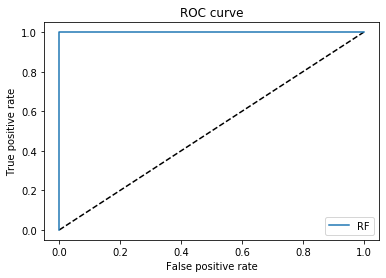

In [166]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### 2、验证集性能

              precision    recall  f1-score   support

           0       0.65      0.65      0.65        60
           1       0.28      0.28      0.28        29

    accuracy                           0.53        89
   macro avg       0.46      0.46      0.46        89
weighted avg       0.53      0.53      0.53        89

Confusion Matrix
[[39 21]
 [21  8]]

Accuracy
0.5280898876404494


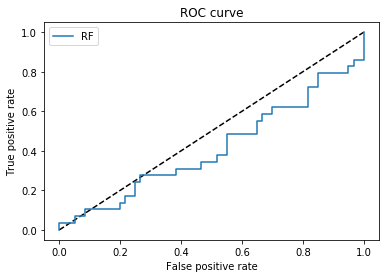

In [167]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [168]:
print(X_validate.index.min())
print(X_validate.index.max())

2012-04-19 13:40:11.617000
2012-06-29 07:00:00.265000


In [169]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2012-04-19 13:40:11.617000')
end = primary_forecast.index.get_loc('2012-06-29 07:00:00.265000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.33      1.00      0.49        29

    accuracy                           0.33        89
   macro avg       0.16      0.50      0.25        89
weighted avg       0.11      0.33      0.16        89

Confusion Matrix
[[ 0 60]
 [ 0 29]]

Accuracy
0.3258426966292135


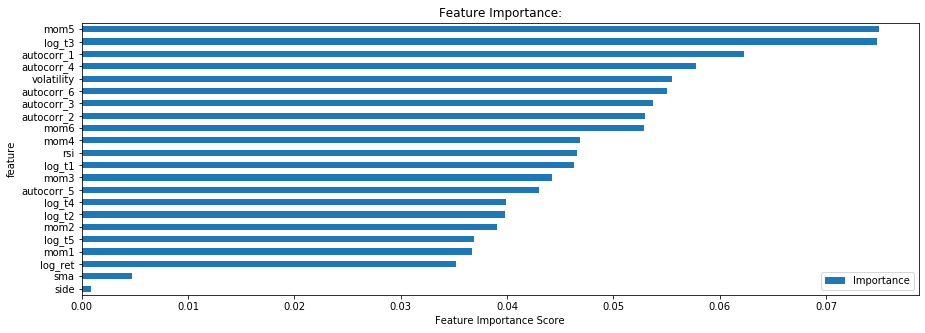

In [170]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

* 回测

## 样品内性能

In [171]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [172]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [173]:
test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)


Start date,2012-04-20
End date,2012-06-29
Total months,2
,Backtest
Annual return,-72.3%
Cumulative returns,-22.9%
Annual volatility,37.1%
Sharpe ratio,-3.27
Calmar ratio,-2.41
Stability,0.85
Max drawdown,-30.0%


In [174]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

# pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)
pf.show_perf_stats(daily_meta_rets)

Start date,2012-04-20
End date,2012-06-29
Total months,2
,Backtest
Annual return,-46.2%
Cumulative returns,-11.8%
Annual volatility,11.2%
Sharpe ratio,-5.46
Calmar ratio,-3.92
Stability,0.90
Max drawdown,-11.8%


## 样本外测试

In [175]:
print(X.index.min())
print(X.index.max())

2011-08-02 17:02:16.995000
2012-07-26 11:53:52.356000


In [176]:
# extarct data for out-of-sample (OOS)
X_oos = X['2012-07-01':]
y_oos = y['2012-07-01':]

              precision    recall  f1-score   support

           0       0.59      0.89      0.71        18
           1       0.67      0.27      0.38        15

    accuracy                           0.61        33
   macro avg       0.63      0.58      0.55        33
weighted avg       0.63      0.61      0.56        33

Confusion Matrix
[[16  2]
 [11  4]]

Accuracy
0.6060606060606061


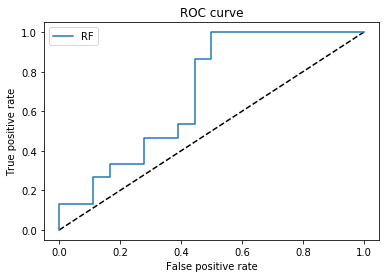

In [177]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [178]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2012-04-01':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.36      1.00      0.52        49

    accuracy                           0.36       138
   macro avg       0.18      0.50      0.26       138
weighted avg       0.13      0.36      0.19       138

Confusion Matrix
[[ 0 89]
 [ 0 49]]

Accuracy
0.35507246376811596


## 样本外性能

In [179]:
test_dates = X_oos.index

base_rets_oos = labels.loc[test_dates, 'ret']
primary_model_rets_oos = get_daily_returns(base_rets_oos)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets_oos, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all


# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets_oos)

Start date,2012-07-04
End date,2012-07-26
Total months,0
,Backtest
Annual return,32.3%
Cumulative returns,1.9%
Annual volatility,40.4%
Sharpe ratio,0.88
Calmar ratio,3.22
Stability,0.10
Max drawdown,-10.0%


Start date,2012-07-04
End date,2012-07-26
Total months,0
,Backtest
Annual return,76.3%
Cumulative returns,3.9%
Annual volatility,15.1%
Sharpe ratio,3.83
Calmar ratio,44.63
Stability,0.74
Max drawdown,-1.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.71,2012-07-24,2012-07-25,NaT,NaN
1,0.71,2012-07-17,2012-07-18,2012-07-24,6
2,0.00,2012-07-04,2012-07-04,2012-07-04,1
3,0.00,2012-07-04,2012-07-04,2012-07-04,1
4,0.00,2012-07-04,2012-07-04,2012-07-04,1


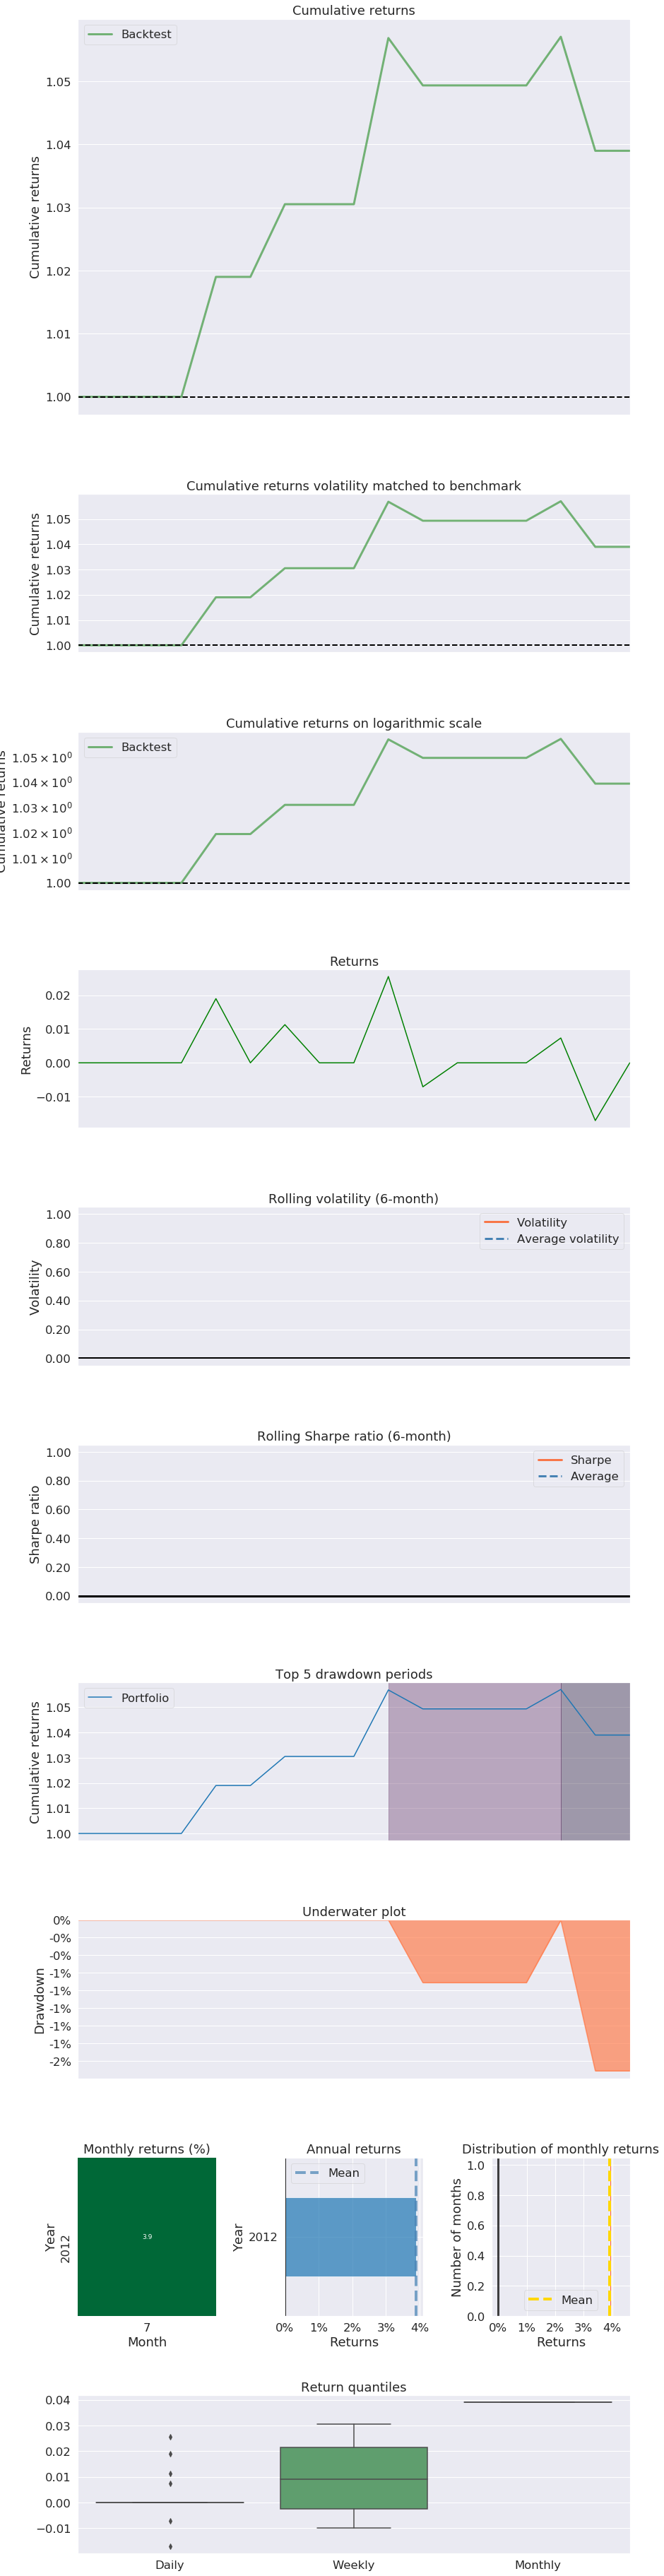

In [180]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

## 结论
布林带均值回归策略：
1. 在样本外测试中，元模型在所有关键统计信息中都执行主模型：
* 年化回报率：32.3%对76.3%
* 年化波动率：40.4%对15.1%
* 夏普比率：0.88对3.83
2. 在所有情况下，元模型（带有元标记的模型）都比原模型降低了年化波动率、最大下降率和增加了夏普比率